## This notebook accomponies the video here

If you have any questions, please post them in the channel page.

In [1]:
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, chi2, ncx2, uniform, pareto

import utilityFuncs as uf

## Data Generating Process

Imagine that the Data Generating Process (DGP) is based on a Gaussian GARCH(1, 1):


$$Z_t \sim \mathcal{N}(0,\,\sigma_{t}^{2})\,.$$
$$\sigma_{t} = a_0 Z_{t-1}^{2} + a_1 \sigma_{t-1}^{2} + a_2$$


and the target variable (i.e., variable to be forecasted) $Y_t$ simply follows

$$Y_t = \mu + Z_t^2$$

Let's code the above DGP.

In [2]:
NUM_DAYS = 183
TEST_INDEX = 153
INITIAL_SIGMA = 1
INITIAL_Z = 0


In [3]:
z_values, sigma_values, days_simulated = uf.simulate_variable_evolution(NUM_DAYS, INITIAL_SIGMA, INITIAL_Z)

In [4]:
MU = 1
y_values = [MU + elem**2 for elem in z_values]

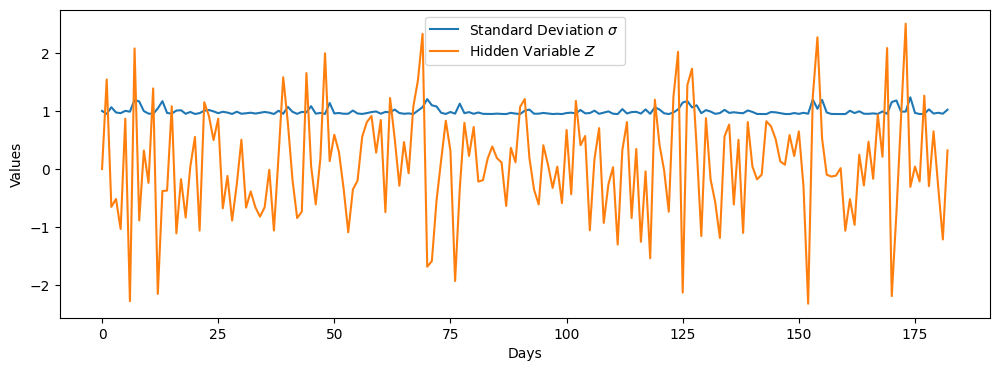

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(days_simulated, sigma_values, label='Standard Deviation $\sigma$')
ax.plot(days_simulated, z_values, label='Hidden Variable $Z$')

ax.set_xlabel('Days')
ax.set_ylabel('Values')

ax.legend()
plt.show()



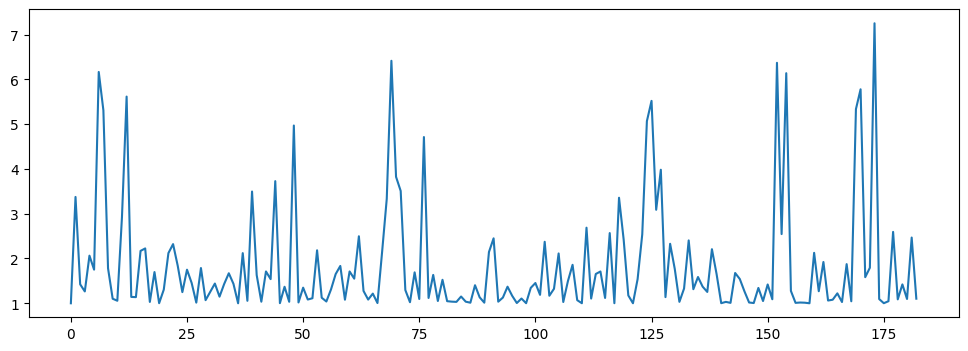

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(days_simulated, y_values, label='True')


Create a dataframe to save days and actual values

In [7]:
df_actual_values = pd.DataFrame({'days': days_simulated, 'actual_values':y_values}, columns=['days','actual_values'])
df_actual_values.to_csv('df_actual_values.csv', sep='\t', float_format='%.4f')


In [8]:
df_actual_values

,days,actual_values
0,0,1.000000
1,1,3.374648
2,2,1.423771
3,3,1.264679
4,4,2.063620
...,...,...
178,178,1.087024
179,179,1.421508
180,180,1.095893
181,181,2.467862


## Expert Forecasts

### Median

Imagine random variable X and it's transformation g(X). If g is monotonic, it will preserve the order between different values of X and thus    $\mathop{\mathbb{M}[g(X)]} = g(\mathop{\mathbb{M}[X]})$ where $\mathbb{M}$ represents median. However, the transformation $Z^2$ that we have in the video is not monotoic so we cannot use this tranformation rule.

In the example above, $\mathbb{M}[Z] = 0$, thus $\mathbb{M}[Z^{2}] = 0$ and $\mathbb{M}[Y] = \mu$

In [9]:
# Forecasts
#expert_forecasts = [MU + elem**2 for elem in sigma_values[TEST_INDEX:]]
expert_forecasts = [MU for elem in sigma_values[TEST_INDEX:]]

In [10]:
shared_data = y_values[0:TEST_INDEX]
mean_value = sum(shared_data)/len(shared_data)
max_value = max(shared_data)
min_value = min(shared_data)

naive_mean_forecasts = [mean_value] * len(expert_forecasts)
naive_max_forecasts = [max_value] * len(expert_forecasts)
naive_min_forecasts = [min_value] * len(expert_forecasts)

In [11]:
TEST_DAYS = [day for day in range(TEST_INDEX, NUM_DAYS)]

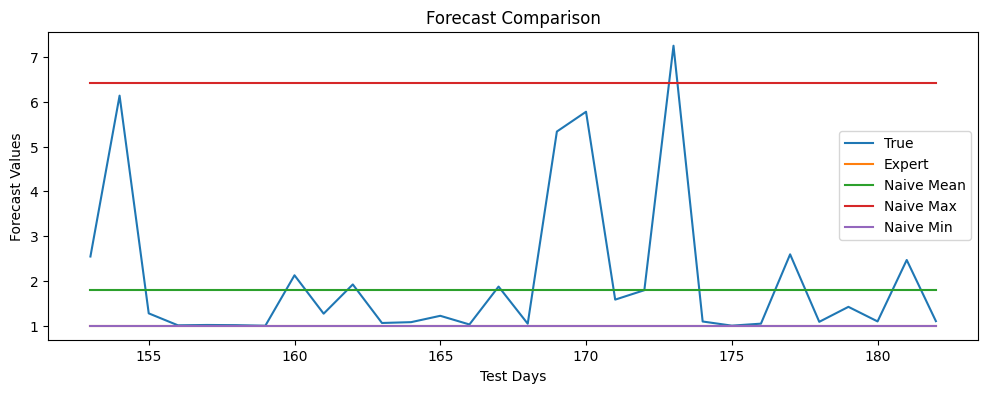

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(TEST_DAYS, y_values[TEST_INDEX:], label='True')
plt.plot(TEST_DAYS, expert_forecasts, label='Expert')
plt.plot(TEST_DAYS, naive_mean_forecasts, label='Naive Mean')
plt.plot(TEST_DAYS, naive_max_forecasts, label='Naive Max')
plt.plot(TEST_DAYS, naive_min_forecasts, label='Naive Min')

plt.xlabel('Test Days')
plt.ylabel('Forecast Values')
plt.title('Forecast Comparison')

plt.legend()
plt.show()


## First Test Day

Let's focus on what happens during the first test day.

In [13]:
sigma_values[TEST_INDEX]

1.196735208584143

/tmp/ipykernel_14552/175434234.py:3: RuntimeWarning: divide by zero encountered in divide
  return (1. / (2. * std * np.sqrt(2. * np.pi * (x - mean)))) * np.exp(-(x - mean) / (2. * std ** 2.))


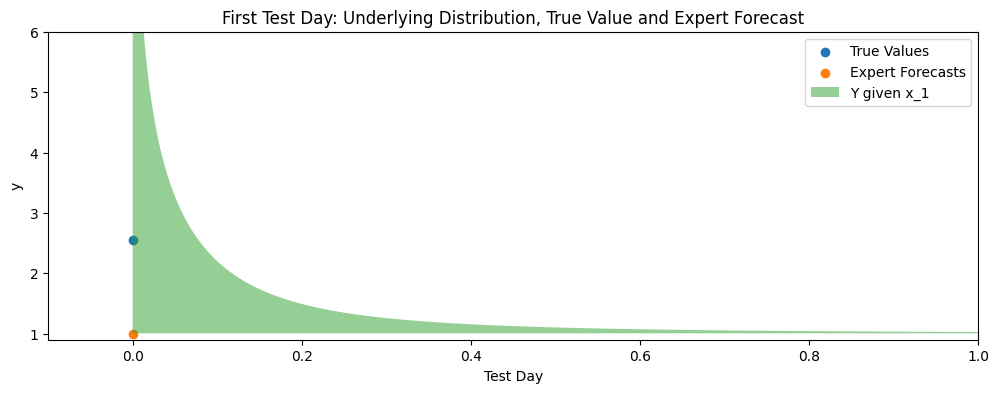

In [14]:
def pdf_expression(mean, std, x):
    #return 1 / (2 * std * np.sqrt(2 * np.pi * (x - mean))) * np.exp(-(np.sqrt(x - mean) - std) ** 2 / (2 * std ** 2))
    return (1. / (2. * std * np.sqrt(2. * np.pi * (x - mean)))) * np.exp(-(x - mean) / (2. * std ** 2.))

def Y_pdf(mean, std):
    return lambda x: pdf_expression(mean, std, x)


x = np.array(TEST_DAYS[:1]) - TEST_DAYS[0]

# Define the values of x_1 and x_2
TEST_IND_1 = 0

x_1 = 0

sig_1 = sigma_values[TEST_INDEX + TEST_IND_1]
#chi2_non_centrality_param = MU**2/(2*sig_1**2)

plt.figure(figsize=(12, 4))

# Plot the curve of y_hat = sin(x)
plt.scatter(x, y_values[TEST_INDEX:TEST_INDEX+1], label='True Values')
plt.scatter(x, expert_forecasts[0:1], label='Expert Forecasts')

# Plot the conditional distribution of Y at x_1 and x_2
for xi, sigi, label in [(x_1, sig_1, 'x_1')]:    
    y = np.linspace(1, 7, 1000)    
    plt.fill_betweenx(y, xi, xi + pdf_expression(MU, sig_1, y), alpha=0.5, label=f'Y given {label}')

# Add legend and labels
plt.legend()
plt.xlabel('Test Day')
plt.ylabel('y')
plt.xlim([-0.1, 1])
plt.ylim([.9, 6])
plt.title('First Test Day: Underlying Distribution, True Value and Expert Forecast')

# Show the plot
plt.show()

In [15]:
#n = 10
n = 10000
y_tildas = np.linspace(MU, MU+4, 100).reshape(-1, 1)

def Y_aux_pdf(mean, std):
    return lambda x: pdf_expression(mean, std, x) / x

#Y_scale = 100
Y_scale = 10
Y, _ = uf.importance_sampling(Y_pdf(MU, sig_1), uniform(loc=MU, scale=Y_scale), n)

# Perform importance sampling on distribution f(y)/y to get samples for the auxiliary variable
Y_aux, weights = uf.importance_sampling(Y_aux_pdf(MU, sig_1), uniform(loc=MU, scale=Y_scale), n)


In [16]:
len(Y [Y == min(Y)])/n

0.0123

In [17]:
print(Y.mean(), expert_forecasts[0])


2.356971226004594 1


In [18]:
# Calculate error metrics
MSE_values = np.mean((Y - y_tildas) ** 2, axis=1)
MAE_values = np.mean(np.abs(Y - y_tildas), axis=1)
MAPE_values = np.mean(np.abs((Y - y_tildas) / Y), axis=1)

In [19]:
np.savetxt('selected_Y.csv', Y, delimiter=',') 
np.savetxt('y_tildas.csv', y_tildas, delimiter=',') 
np.savetxt('MSE_values.csv', MSE_values, delimiter=',') 

Text(0.5, 0.98, 'First Test Day: Underlying Distribution, True Value and Expert Forecast')

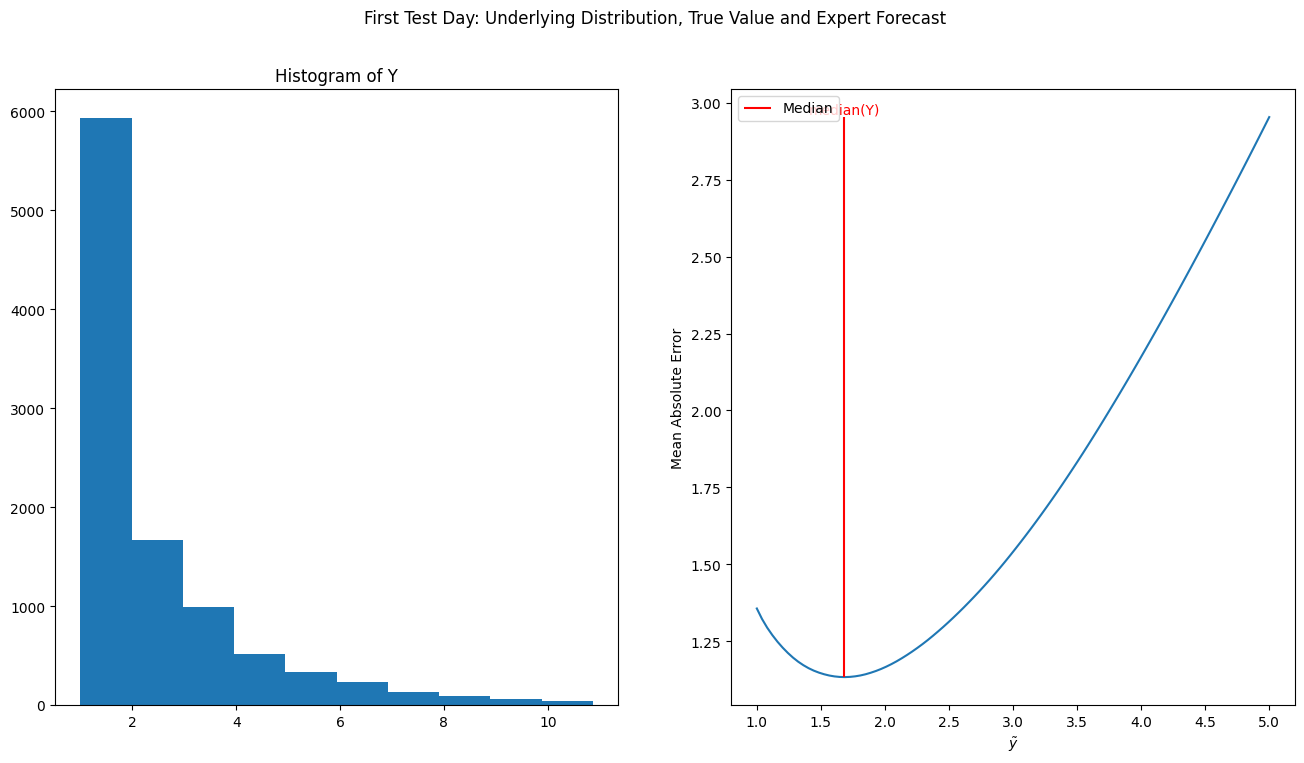

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].hist(Y)
axes[0].set_title("Histogram of Y")


axes[1].plot(y_tildas, MAE_values)
axes[1].vlines(np.median(Y), ymin=min(MAE_values), ymax=max(MAE_values), colors="r", label="Median")
axes[1].set_ylabel("Mean Absolute Error")
axes[1].set_xlabel(r"$\tilde{y}$")
axes[1].text(np.median(Y), max(MAE_values), f'median(Y)', ha='center', va='bottom', color='r', fontsize=10)
axes[1].legend()



fig.suptitle('First Test Day: Underlying Distribution, True Value and Expert Forecast')


### Rest still Under Construction.

In [21]:
data = {'tst_days': TEST_DAYS,
        'expert': expert_forecasts,
        'naive_mean': naive_mean_forecasts,
        'naive_max': naive_max_forecasts,
        'naive_min': naive_min_forecasts,
        'actual_values': y_values[TEST_INDEX:]
       }

df_forecasts = pd.DataFrame(data)


# write the DataFrame to a CSV file with specific formatting options
df_forecasts.to_csv('df_forecasts.csv', sep='\t', float_format='%.4f')

In [22]:
df_forecasts

,tst_days,expert,naive_mean,naive_max,naive_min,actual_values
0,153,1,1.80485,6.415091,1,2.545541
1,154,1,1.80485,6.415091,1,6.137902
2,155,1,1.80485,6.415091,1,1.276120
3,156,1,1.80485,6.415091,1,1.009496
4,157,1,1.80485,6.415091,1,1.016723
5,158,1,1.80485,6.415091,1,1.012706
6,159,1,1.80485,6.415091,1,1.000272
7,160,1,1.80485,6.415091,1,2.126338
8,161,1,1.80485,6.415091,1,1.269318
9,162,1,1.80485,6.415091,1,1.921786


In [23]:
# define forecasters and their corresponding forecasts
forecasters = {'expert': expert_forecasts,
               'min': naive_min_forecasts,
               'mean': naive_mean_forecasts,
               'max': naive_max_forecasts}

# initialize errors dataframe
errors = pd.DataFrame(index=['expert', 'min', 'mean', 'max'], columns=['MAE', 'MSE', 'MAPE', 'adjustedMAPE'])

# calculate errors for each forecaster
for forecaster, forecast_values in forecasters.items():
    Y_forecast = forecast_values
    Y_true = y_values[TEST_INDEX:]

    # calculate errors
    MSE = mean_squared_error(Y_true, Y_forecast)
    MAE = mean_absolute_error(Y_true, Y_forecast)
    MAPE = mean_absolute_percentage_error(Y_true, Y_forecast)
    adjustedMAPE = uf.calculate_adjusted_MAEP(Y_true, Y_forecast)

    # save errors to errors dataframe
    errors.loc[forecaster, 'MSE'] = MSE
    errors.loc[forecaster, 'MAE'] = MAE
    errors.loc[forecaster, 'MAPE'] = MAPE
    errors.loc[forecaster, 'adjustedMAPE'] = adjustedMAPE

In [24]:
errors.to_csv('df_errors.csv', sep='\t', float_format='%.4f')


<AxesSubplot: >

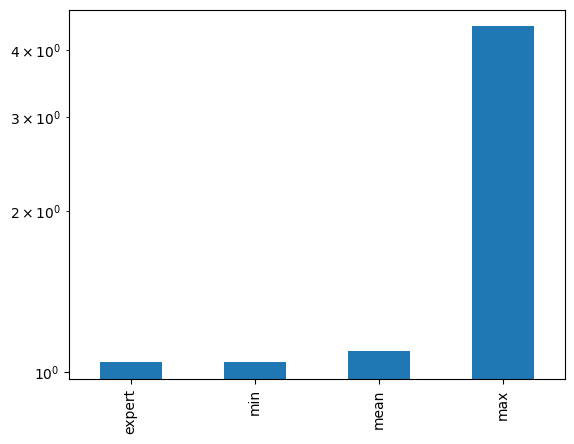

In [25]:
errors.sort_values(by=['MAE'])['MAE'].plot.bar(logy=True)

<AxesSubplot: >

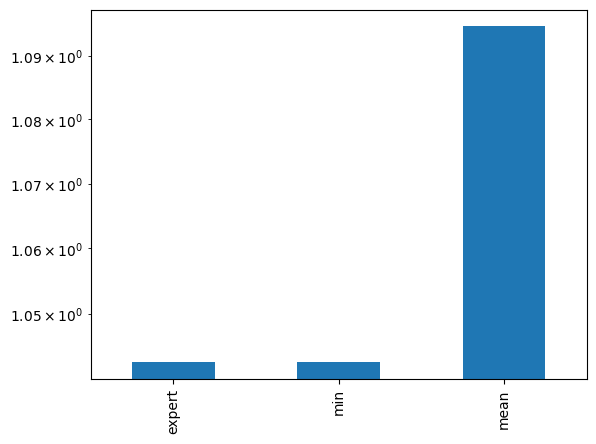

In [36]:
errors.loc[['expert', 'min', 'mean'], :].sort_values(by=['MAE'])['MAE'].plot.bar(logy=True)